# Принятие решений в бизнес-аналитике

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.


**Данные для первой части**

Файл [/datasets/hypothesis.csv](https://code.s3.yandex.net/datasets/hypothesis.csv)
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные для второй части**

Файл [/datasets/orders.csv](https://code.s3.yandex.net/datasets/orders.csv)
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл [/datasets/visitors.csv](https://code.s3.yandex.net/datasets/visitors.csv)
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Общая информация

In [1]:
# подключим необходимые библиотеки и настройки отображения

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.display.max_colwidth = 100

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# прочитаем датасеты из файлов и запишем в переменные

hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# посмотрим информацию о датасете hypothesis

hypothesis.info()
hypothesis.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# посмотрим информацию о датасете orders

orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
# находим крайние даты заказов
min_order_date = orders['date'].min()
max_order_date = orders['date'].max()

In [6]:
min_order_date

'2019-08-01'

In [7]:
max_order_date

'2019-08-31'

В наборе данных рассматриваем промежуток заказов за месяц: с 01.08.2019 по 31.08.2019.

In [8]:
# смотрим количество пользователей в обеих группах
orders.groupby('group').agg({'visitorId' : 'nunique'})

,visitorId
group,
A,503
B,586


<div class="alert alert-info"> <b>Комментарий:</b> Выборки различаются. По-хорошему, нужно удалить дубликаты пользователей и выровнять результат. 
Но преподаватель курса написал, что "именно для этого исследования не важно, результаты будут такими же". Поэтому не буду заострять на этом внимание.</div>



In [9]:
# посмотрим информацию о датасете visitors

visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Похоже, что данные в целом в порядке – пропущенных значений не обнаружено.

Нужно поправить стилистические недочеты в названиях столбцов некоторых датафреймов и привести столбцы о времени к корректному типу данных.

In [10]:
# приведем названия столбцов к нижнему регистру
hypothesis = hypothesis.rename(str.lower, axis='columns')

# переименуем названия столбцов в snake_case
orders = orders.rename(columns={'transactionId': 'transaction_id' \
                                , 'visitorId': 'visitor_id'})

# преобразуем данные о времени для дальнейших расчётов
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


**Вывод по шагу:**

У нас есть 3 датасета с данными: список гипотез, а также список заказов за месяц и список с количеством посещений. 

Пропущенных значений не обнаружено. Недочеты в наименованиях столбцов и типах данных исправлены. 

Данные готовы к анализу.

## Анализ данных


### Часть 1. Приоритизация гипотез.

**Задание:** В файле `hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

1. Применим фреймворк `ICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [11]:
hypothesis['ICE'] = (hypothesis['impact'] \
                     * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


По методу оценки приоритетов `ICE`: 8 гипотеза самая перспективная, далее идут 
гипотезы 0 и 7.

2. Применим фреймворк `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.


In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] \
                      * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


По методу оценки приоритетов `RICE`: 7 гипотеза самая перспективная, далее идут 
гипотезы 2, 0 и 6. 

При этом гипотеза 8, которая была первой по методу оценки `ICE`, опустилась в рейтинге на 5 место.

**Вывод по части:**

Приоритезация именилась из-за высокой ценности параметра Reach, который оценивается только по методу `RICE`: у 7 гипотезы – 10 баллов. В то же время у гипотезы 8 этот показатель самый низкий – 1 балл, поэтому ее приоритет снизился.

Если кроме силы гипотез учитывается сколько пользователей затронет изменение, то гипотеза номер 7 выглядит наиболее перспективной.

Мы убедились, как важно учитывать объем пользователей, на которых скажется изменение, чтобы выбрать верную гипотезу для тестирования.


### Часть 2. Анализ A/B-теста.

**Задание:** Мы провели A/B-тест и получили результаты, которые описаны в файлах `orders.csv` и `visitors.csv`.

Проанализируем A/B-тест:

In [13]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.

In [14]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups \
  .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], \
                                         orders['group'] == x['group'])] \
         .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', \
               'visitor_id' : 'nunique', 'revenue' : 'sum'}), \
          axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups \
  .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
                                           visitors['group'] == x['group'])] \
         .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), \
         axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, \
                                        left_on=['date', 'group'], \
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', \
                          'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


1. Построим график кумулятивной выручки по группам. 

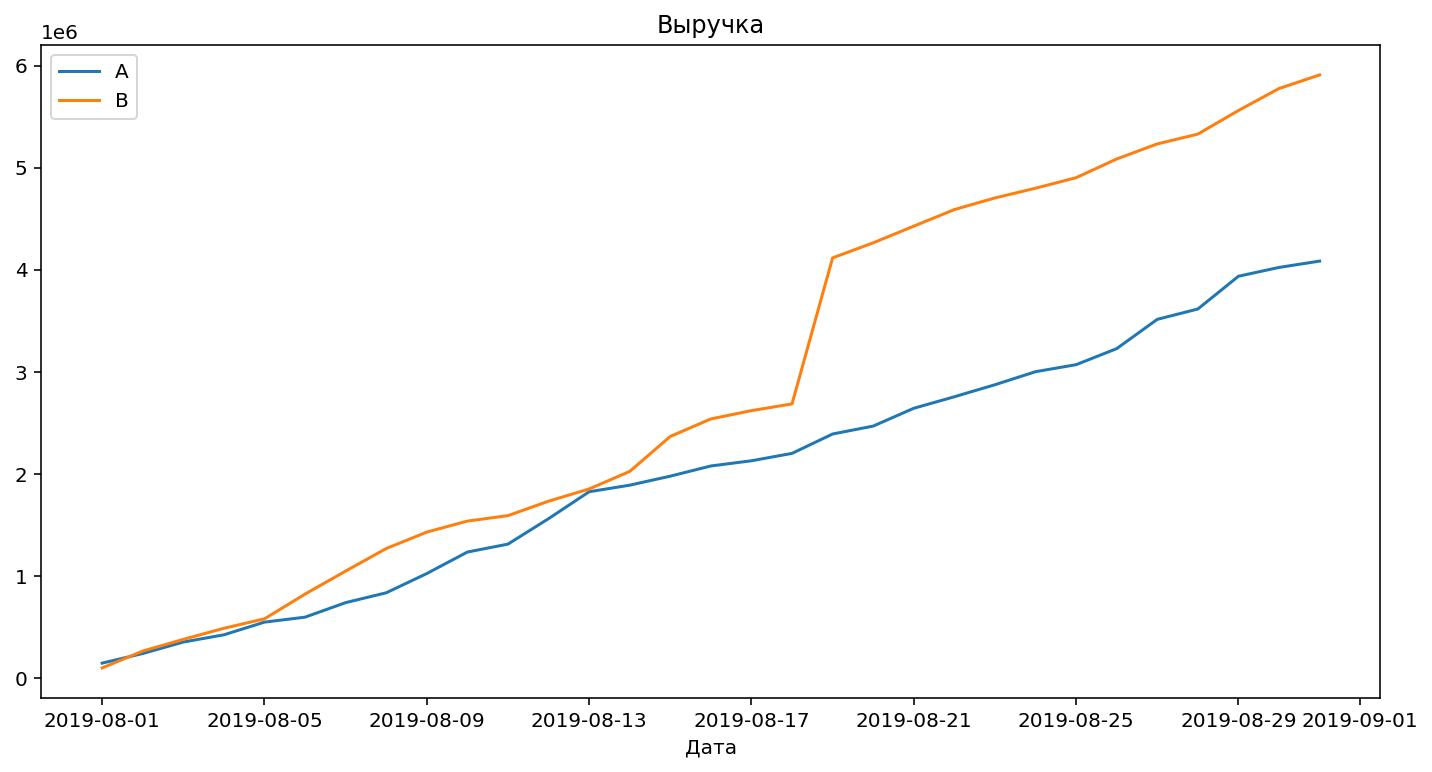

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'] \
  [['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'] \
  [['date','revenue', 'orders']]

plt.figure(figsize=(12,6))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.title('Выручка')
plt.legend();

Выручка увеличивается в течение всего месяца в обеих группах.

В середине теста выручка по группе B вырвалась вперед и продолжала лидировать весь остаток теста. 

Это может сигнализировать о всплесках числа заказов в этой группе, либо о появлении очень дорогих заказов в выборке. Такие выбросы при заключительном анализе нужно проанализировать и исключить.

2. Построим график кумулятивного среднего чека по группам.

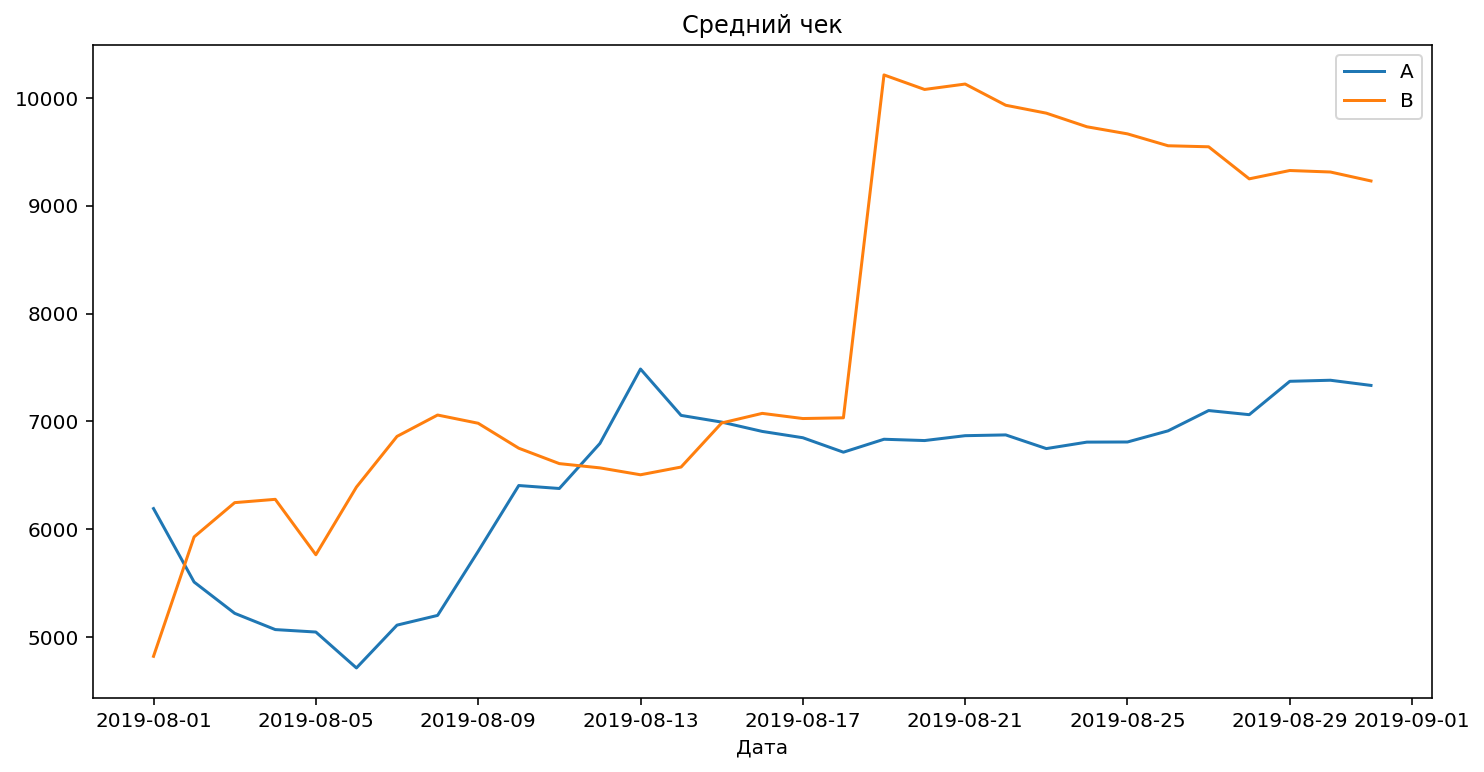

In [16]:
# Построим графики среднего чека по группам:
plt.figure(figsize=(12,6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] \
        /cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] \
         /cumulativeRevenueB['orders'], label='B')

plt.xlabel('Дата')
plt.title('Средний чек')
plt.legend();

Средний чек тоже вырос за месяц теста.

В группе A было падение среднего чека в начале теста, но затем резко увеличился и стабилизировался на одном уровне с середницы до конца теста. 

В группе B чек резко вырос на 50% в середине месяца, а затем стал плавно снижаться. Возможно, в эту группу во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

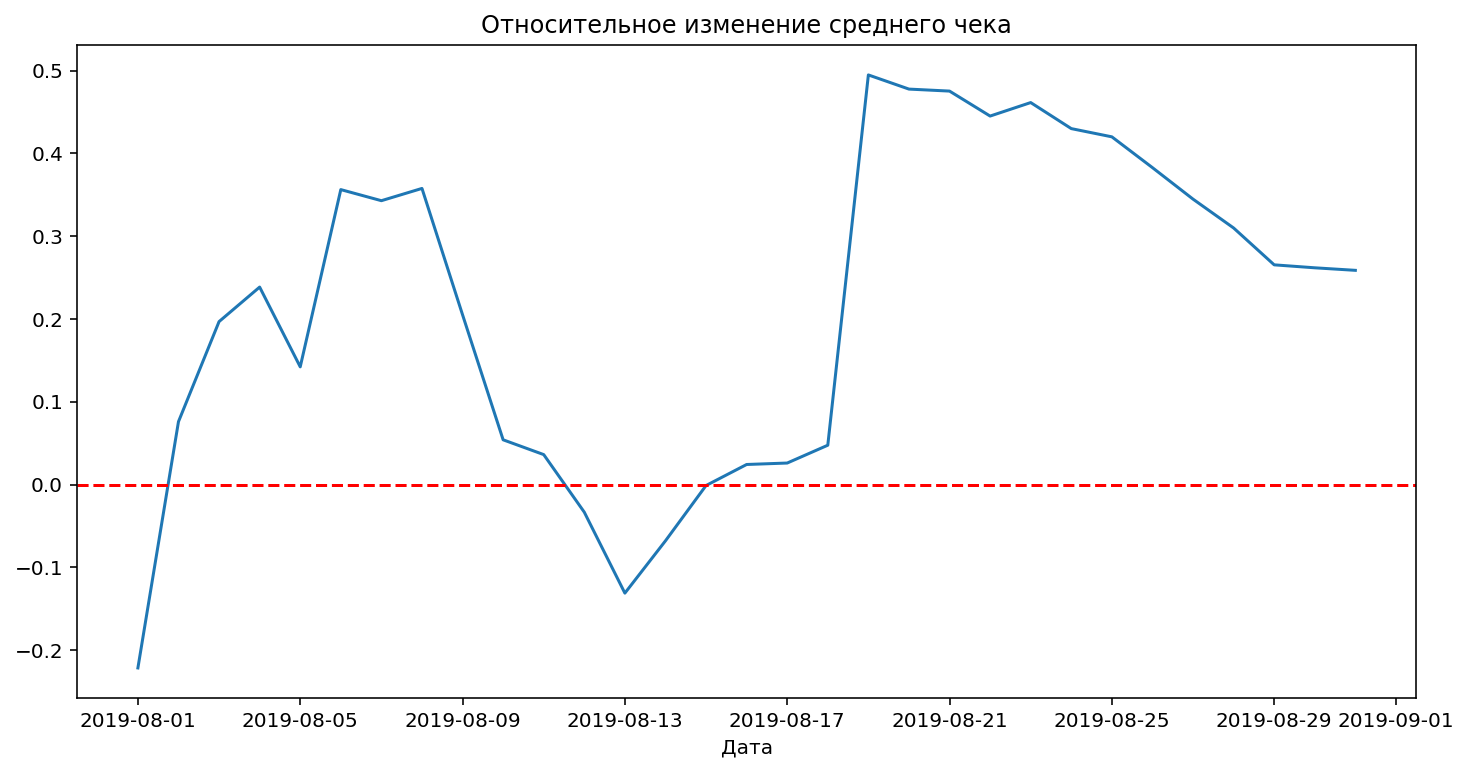

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, \
   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeRevenue['date'], \
         (mergedCumulativeRevenue['revenueB'] \
          /mergedCumulativeRevenue['ordersB']) \
         /(mergedCumulativeRevenue['revenueA'] \
           /mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Дата')
plt.title('Относительное изменение среднего чека');

На протяжении всего теста график различия между сегментами резко «скачет». 

Похоже, что в заказах много аномалий. Найдем их позже.


4. Построим график кумулятивной конверсии по группам. 

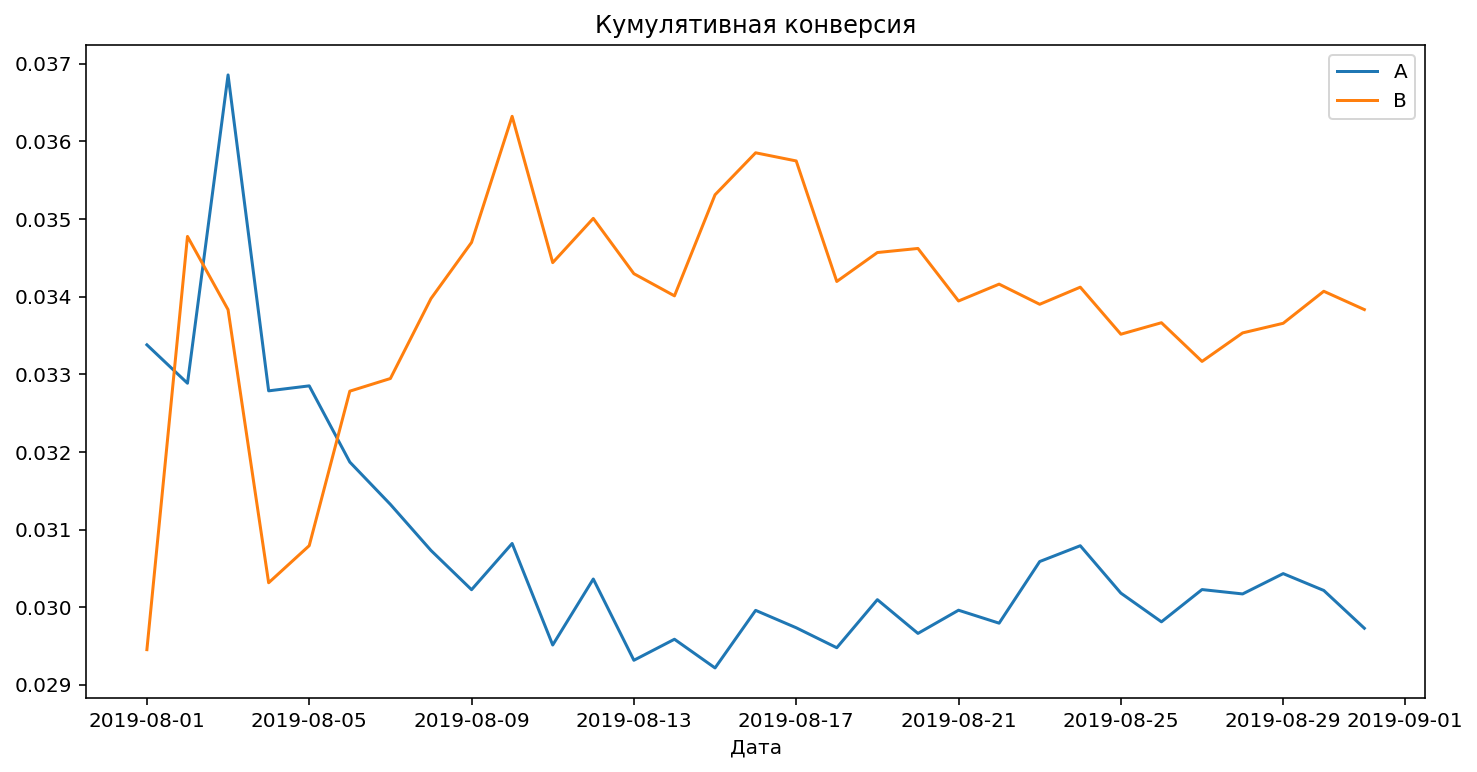

In [18]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] \
  /cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.title('Кумулятивная конверсия');

Первые несколько дней теста конверсия сильно скакала у обеих групп, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.


5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.


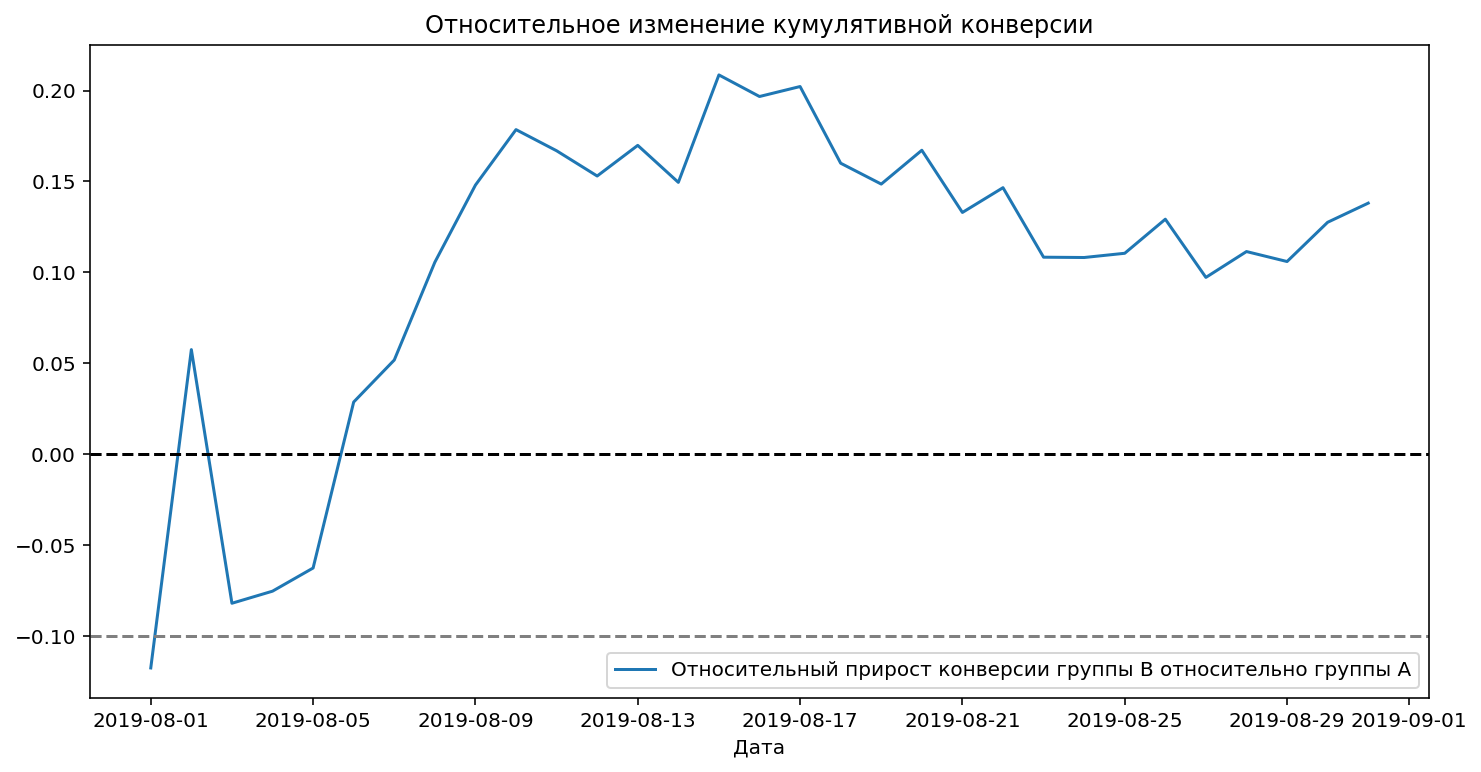

In [19]:
# строим график относительного различия кумулятивных конверсий

mergedCumulativeConversions = cumulativeDataA[['date','conversion']] \
  .merge(cumulativeDataB[['date','conversion']], \
         left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))

plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB'] \
         /mergedCumulativeConversions['conversionA']-1, \
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.title('Относительное изменение кумулятивной конверсии');

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.

В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

6. Построим точечный график количества заказов по пользователям. 


Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. 

In [20]:
# подсчитаем количество заказов по пользователям и посмотрим на результат:

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Имеются пользователи, которые совершали 5, 8, 9 и 11 заказов. Проверим, намного ли это больше, чем обычное количество заказов за неделю.

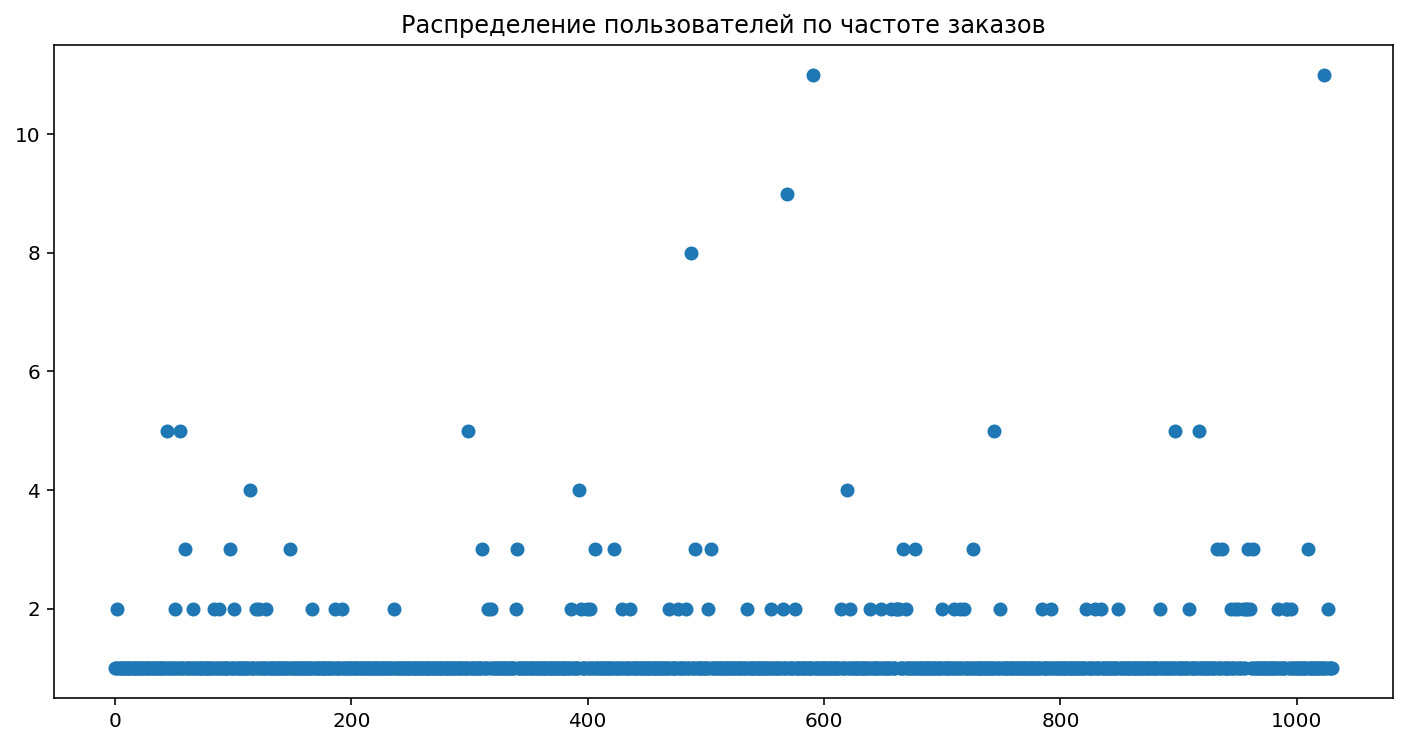

In [21]:
# построим точечную диаграмму числа заказов

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Распределение пользователей по частоте заказов');

Выводы подтверждаются: подавляющая часть пользователей с 1 заказом, довольно много с 2. 

Некоторое количество пользователей с количеством заказов в месяц до 4.

Единичны случаи 4-11 заказов в месяц.


7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.


In [22]:
# посчитаем выборочные перцентили количества заказов

np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершило более 2 заказа. Не более 1% купило за месяц более 4 раз.

За крайнюю границу выбросов можно считать 4 заказа.

8. Построим точечный график стоимостей заказов. 


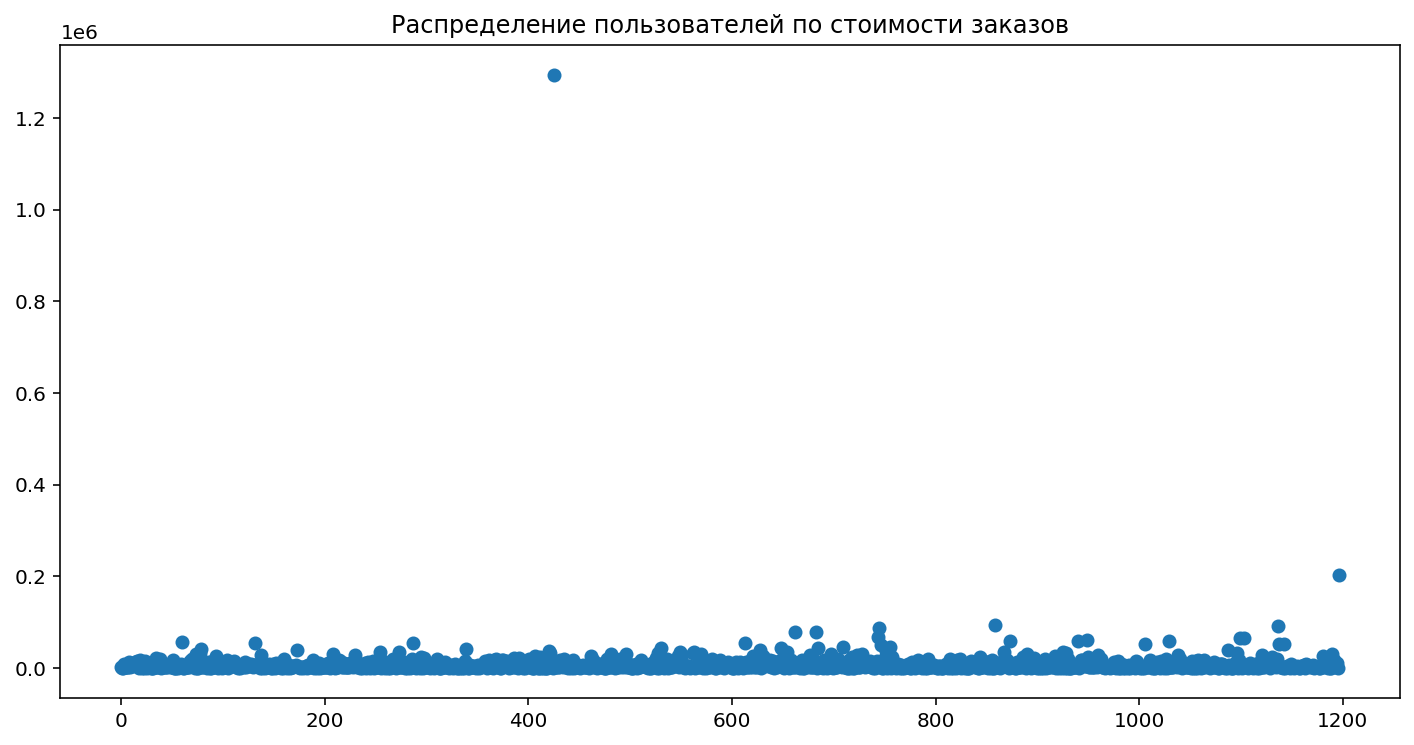

In [23]:
# построим точечную диаграмму стоимостей заказов
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение пользователей по стоимости заказов');

Обнаружено несколько дорогих заказов-выбросов, один из которых – экстремально сильно отличается от остальных и составляет более 1.2 млн.

9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.


In [24]:
# посчитаем выборочные перцентили стоимости заказов

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% пользователей совершает покупку стоимостью 28000 рублей. Не более 1% купило на 58233 рубля.

Все суммы выше последней можно считать выбросами и исключить из анализа.

Мы онаружили, что в данных присутствуют аномалии. Продолжим анализ, учитывая этот момент и попытаемся вычислить корректные показатели.

**Теперь посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.**

#### Подготовка «сырых» данных

In [25]:
# подготовим данные для анализа, собрав новый датафрейм с нужными значениями

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [26]:
data.head(5).T

,0,1,2,3,4
date,2019-08-01 00:00:00,2019-08-02 00:00:00,2019-08-03 00:00:00,2019-08-04 00:00:00,2019-08-05 00:00:00
ordersPerDateA,24,20,24,16,25
revenuePerDateA,148579,93822,112473,70825,124218
ordersPerDateB,21,24,16,17,23
revenuePerDateB,101217,165531,114248,108571,92428
ordersCummulativeA,24,44,68,84,109
revenueCummulativeA,148579,242401,354874,425699,549917
ordersCummulativeB,21,45,61,78,101
revenueCummulativeB,101217,266748,380996,489567,581995
visitorsPerDateA,719,619,507,717,756


Названия столбцов данных:

- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

#### Анализ «сырых» данных

10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.


**Гипотеза 1: Различий в конверсии между группами A и B нет**


- $H_0$: различий в конверсии между группами нет. 
- $H_1$: различия в конверсии между группами есть.


In [27]:
# создадим переменные с пользователями обеих групп хотя бы с 1 заказом и укажем число заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

# объявим переменные, где пользователям разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


По «сырым» данным видим различие в конверсии групп A и B.

Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. 

**Относительный прирост конверсии группы B равен 13.8%.**

11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.


**Гипотеза 2: Различий в среднем чеке между группами A и B нет**


- $H_0$: различий в среднем чеке между группами нет. 
- $H_1$: различия в среднем чеке между группами есть.

In [28]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A'] \
                                          ['revenue'], \
                                          orders[orders['group']=='B']\
                                          ['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'] \
                       .mean()/orders[orders['group']=='A']\
                       ['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

**По этим данным средний чек группы B выше среднего чека группы A на 25.9%.**


**Вывод по «сырым» данным:** группа B показывает лучшие результаты по конверсии в сравнении с группой A на 13.8%, а по среднему чеку на 25.9%.

#### Подготовка «очищенных» данных

Напомним, что найденные в прошлых шагах 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. 

А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

Сделаем срезы пользователей с числом заказов больше 2 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 30 000 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`.


In [29]:
# узнаем, сколько всего аномальных пользователей методом shape()

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


abnormalUsers.shape

(68,)

Видим 68 пользователей с аномальными заказами, выходящими за рамки среза – это довольно много, около 7%.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

Подготовим выборки количества заказов по пользователям по группам теста.

In [30]:
# создание выборок количества заказов по группам теста

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 


**Гипотеза 1: Различий в конверсии между группами A и B нет**


- $H_0$: различий в конверсии между группами нет. 
- $H_1$: различия в конверсии между группами есть.


In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.172


По «очищенным» данным тоже видим различие в конверсии групп A и B.

Первое число — p-value = 0.007 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. 

**Относительный прирост конверсии группы B равен 17.2%.**

13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

**Гипотеза 2: Различий в среднем чеке между группами A и B нет**


- $H_0$: различий в среднем чеке между группами нет. 
- $H_1$: различия в среднем чеке между группами есть.

In [32]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.720
-0.023


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

**Хотя теперь выясняется, что средний чек группы B меньше среднего чека группы A на 2.3%. Но это не статистически значимо.**



**Вывод по «очищенным» данным:** результаты теста изменились – аномалии сильно повлияли на результаты A/B-теста и исказили реальную картину почти до обратного результата.

Относительный прирост конверсии группы B по «очищенным» данным равен 17.2%, но средний чек немного ниже группы A – на 2.3% (что не является статистически значимым).

## Общий вывод

Имеющиеся факты:
- Есть статистически значимое различие по конверсии между группами как по «сырым данным», так и после фильтрации аномалий. Минимум на 13.8% конверсия группы B лучше
- По «сырым данным», средний чек группы B выше, но по отфильтрованным от выбросов – на 2.3% ниже. По очищенным данным нет статистически значимого различия по среднему чеку между группами
- График различия конверсии между группами сообщает, что результаты группы B намного и стабильно выше группы A
- График различия среднего чека колеблется, но сделать из этого графика определённые выводы нельзя


Исходя из обнаруженных фактов, **тест следует остановить и зафиксировать победу группы B**. 

Повышенная конверсия показывает, что в будущем можно получить прибыль выше. А статистически незначимое падение среднего чека можно пока проигнорировать, передав маркетологам и отделу продаж задачу на увеличение среднего чека в принципе.